In [1]:
import random
import pprint
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete
!pip install colorama
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.pyplot as plt
np.random.seed(20)
random.seed(20)

In [2]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape

    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      # P[s][a] = (prob, next_state, reward, is_done)
      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,45,63,64] + [i for i in range(10)]
      no_down = lambda s: s in [23,24,25,44] + [i for i in range(90, 100)]
      no_left = lambda s: s in [44,36,55] + [i for i in range(0, 91, 10)]
      no_right = lambda s: s in [32,42,52] + [i for i in range(9, 100, 10)]

      #Barries in the path
      pit = lambda s: s in [13,62,41]

      #Rewards of each state
      reward = 100.0 if is_done(s) else -0.5
      reward = -10.0 if pit(s) else reward
      
      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      if s == 1:
        P[s][LEFT] = [(1, ns_left, 100.0, True)]
        P[s][UP] = [(0.8, ns_up, reward, is_done(ns_up)), (0.2, ns_left, reward, is_done(ns_left))]
      elif s == 10:
        P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]
        P[s][UP] = [(0.8, ns_up, 100.0, True), (0.2, ns_left, reward, is_done(ns_left))]
      else:
        P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]
        P[s][UP] = [(0.8, ns_up, reward, is_done(ns_up)), (0.2, ns_left, reward, is_done(ns_left))]
      
      P[s][RIGHT] = [(0.8, ns_right, reward, is_done(ns_right)), (0.2, ns_left, reward, is_done(ns_left))]
      P[s][DOWN] = [(0.8, ns_down, reward, is_done(ns_down)), (0.2, ns_left, reward, is_done(ns_left))]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1.0, s, -3.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1.0, s, -3.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1.0, s, -3.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1.0, s, -3.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[44]=1
    self.P = P

    super(GridworldEnv, self).__init__(nS, nA, P, isd)

  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,62,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,62,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,35,54]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()


def main():
  env =  GridworldEnv()
  env.reset()
  env._render()

  for _ in range(4):
      action = env.action_space.sample()
      state, reward, done, info = env.step(action) # Take a random action
      print(info)
      print('action:',action)
      env._render()
  env.close()

Sarsa Agent

In [3]:
num_episode=350
n=200

In [4]:
class SarsaAgent:
  def __init__(self, env: GridworldEnv,eps_decay=False,alpha_decay=False):
    self.env = env
    self.possible_actions = np.arange(self.env.nA)  # [0,1,2,3]
    self.Q=np.zeros((100,4))
    self.max_steps=500
    self.episodes_reward=[]
    self.epsilon_a=20
    self.alpha=0.4
    self.gamma=0.8
    self.eps_decay=eps_decay
    self.alpha_decay=alpha_decay


  def Epsilon(self,episode):
    if self.eps_decay:
      return self.epsilon_a/(100+episode)
    else:
      return self.epsilon_a/100
  
  def Alpha(self,episode):
    if self.alpha_decay:
      return self.alpha*(0.98)**episode
    else:
      return self.alpha
   
  def greedy(self,state):
    return np.argmax(self.Q[int(state)])

  def epsilon_greedy(self,state,episode):
    rand_num=random.random()
    if rand_num < self.Epsilon(episode):
      return np.random.choice(self.possible_actions, p=[0.25, 0.25, 0.25, 0.25])
    else:
      return self.greedy(state)


  def take_action(self,num_episode):
    self.episodes_reward=[]
    
    for episode in range(num_episode):
      epi_reward=[]

      self.env.reset()
      done=False
      state=int(np.where(self.env.isd == 1)[0])

      action=self.epsilon_greedy(state,episode)
      for a_step in range(self.max_steps):        
        state_prime ,reward, done, _ = self.env.step(action)
        action_prime=self.epsilon_greedy(state_prime,episode)
        self.Q[state][action]=(1-self.Alpha(episode))*self.Q[state][action]+self.Alpha(episode)*(reward+self.gamma*self.Q[state_prime][action_prime])
        epi_reward.append(reward)
        state=state_prime
        action=action_prime
        if done:
          break
      self.episodes_reward.append(sum(epi_reward))

  def application(self):
    self.env.reset()
    done=False
    state=int(np.where(self.env.isd == 1)[0])

    re_lst=[]
    
    for a_step in range(self.max_steps):
      action=self.epsilon_greedy(state,0)
      state_prime ,reward, done, _ = self.env.step(action)
      re_lst.append(reward)
      state=state_prime
      if done:
        break
    return sum(re_lst)

class for repeating sarsa algorithm

In [5]:
class repeat_sarsa:
  def __init__(self,eps_decay=False,alpha_decay=False):
    self.eps_decay=eps_decay
    self.alpha_decay=alpha_decay
    self.sarsa_agent=None
    self.ER_list_mean=None
    self.app_reward=None
  def n_times(self,num_episode,n):
    self.ER_list_mean=[]
    self.app_reward=[]
    env = GridworldEnv()
    env._render()
    for i in range(n):
      self.sarsa_agent=SarsaAgent(env=env,eps_decay=self.eps_decay,alpha_decay=self.alpha_decay)
      self.sarsa_agent.take_action(num_episode)
      self.ER_list_mean.append(self.sarsa_agent.episodes_reward)
      self.app_reward.append(self.sarsa_agent.application())
    L=len(self.ER_list_mean)
    L1=len(self.ER_list_mean[0])
    lst=[]
    
    for i in range(L1):
      sum_n=0
      for j in range(L):
        sum_n=sum_n+self.ER_list_mean[j][i]
      lst.append(sum_n/n)

    self.ER_list_mean=lst


A Sarsa agent

       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
rewards in each episode: [60.0, 39.0, 20.0, -257.5, -58.5, -12.0, 72.5, 70.5, 93.5, 31.0, -13.5, 83.5, 88.5, 49.0, 87.5, 85.0, 44.0, 3.5, 82.5, 77.5, 80.5, 73.0, 71.0, 78.5, 83.0, 96.5, 84.0, 70.5, 92.5, 95.0, 81.5, 83.5, 94.5, -45.0, 47.0, -30.5, 91.0, -43.0, 39.5, -122.0, 96.0, 82.0, 84.5, 87.5, 76.5, 93.5, 86.5, 88.0, -109.5, 79.5, 79.0, 73.5, 96.5, 95.5, 89.5, 79.5, 92.5, 82.5, 96.5, 93.5, 51.0, 91.5, 52.5, 72.5, 86.5, 92.5, 83.5, 96.5, 87.0, 83.5, 90.5, 91.0, 87.5, 91.5, 93.5, 94.5

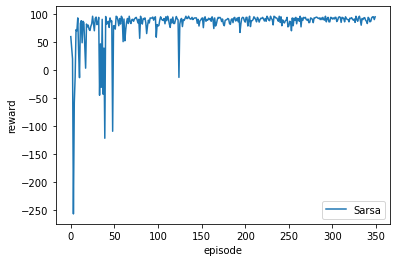

In [6]:
env = GridworldEnv()
env._render()
one_sarsa_agent = SarsaAgent(env=env)
one_sarsa_agent.take_action(num_episode)
plt.plot(list(range(len(one_sarsa_agent.episodes_reward))),one_sarsa_agent.episodes_reward)
print('rewards in each episode:',one_sarsa_agent.episodes_reward)
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend(['Sarsa'])

Repeating Sarsa Algorithm for 200 times
and Calculating the average

       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
mean application reward is 87.1925


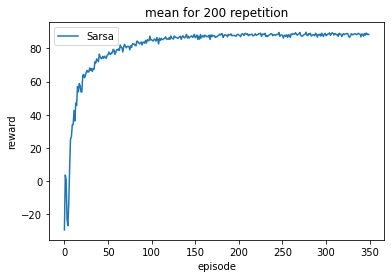

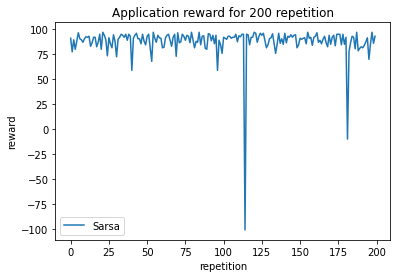

In [7]:
Sarsa_Algorithm=repeat_sarsa()
Sarsa_Algorithm.n_times(num_episode,n)

plt.plot(list(range(len(Sarsa_Algorithm.ER_list_mean))),Sarsa_Algorithm.ER_list_mean)
plt.title('mean for {} repetition'.format(n))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend(['Sarsa'])

plt.figure()
plt.plot(list(range(len(Sarsa_Algorithm.app_reward))),Sarsa_Algorithm.app_reward)
plt.title('Application reward for {} repetition'.format(n))
plt.xlabel('repetition')
plt.ylabel('reward')
plt.legend(['Sarsa'])
print('mean application reward is {}'.format(sum(Sarsa_Algorithm.app_reward)/len(Sarsa_Algorithm.app_reward)))


Sarsa with epsilon decay

       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
mean application reward is 88.1675


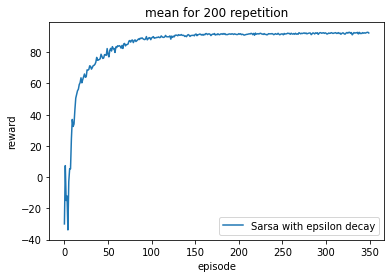

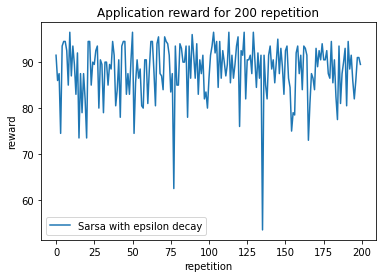

In [8]:
Sarsa_eps_decay=repeat_sarsa(eps_decay=True)
Sarsa_eps_decay.n_times(num_episode,n)

plt.plot(list(range(len(Sarsa_eps_decay.ER_list_mean))),Sarsa_eps_decay.ER_list_mean)
plt.title('mean for {} repetition'.format(n))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend(['Sarsa with epsilon decay'])



plt.figure()
plt.plot(list(range(len(Sarsa_eps_decay.app_reward))),Sarsa_eps_decay.app_reward)
plt.title('Application reward for {} repetition'.format(n))
plt.xlabel('repetition')
plt.ylabel('reward')
plt.legend(['Sarsa with epsilon decay'])
print('mean application reward is {}'.format(sum(Sarsa_eps_decay.app_reward)/len(Sarsa_eps_decay.app_reward)))

Sarsa with alpha decay

       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  


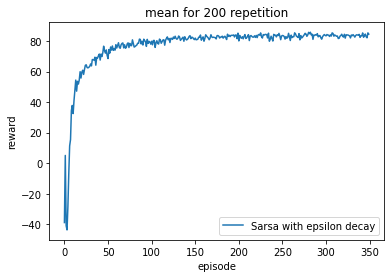

In [9]:
Sarsa_alpha_decay=repeat_sarsa(alpha_decay=True)
Sarsa_alpha_decay.n_times(num_episode,n)

plt.plot(list(range(len(Sarsa_alpha_decay.ER_list_mean))),Sarsa_alpha_decay.ER_list_mean)
plt.title('mean for {} repetition'.format(n))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend(['Sarsa with epsilon decay'])

Sarsa Comparison

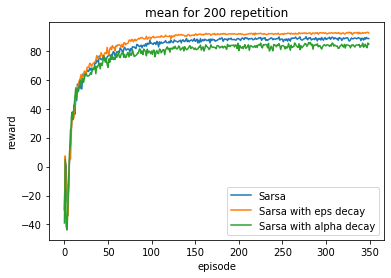

In [10]:
plt.plot(list(range(len(Sarsa_Algorithm.ER_list_mean))),Sarsa_Algorithm.ER_list_mean)
plt.plot(list(range(len(Sarsa_eps_decay.ER_list_mean))),Sarsa_eps_decay.ER_list_mean)
plt.plot(list(range(len(Sarsa_alpha_decay.ER_list_mean))),Sarsa_alpha_decay.ER_list_mean)
plt.title('mean for {} repetition'.format(n))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend(['Sarsa','Sarsa with eps decay','Sarsa with alpha decay'])

Regret

Text(0, 0.5, 'regret')

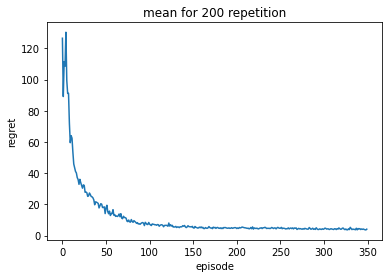

In [11]:
max_reward=96.5
regret=[max_reward-i for i in Sarsa_eps_decay.ER_list_mean]
plt.plot(list(range(len(regret))),regret)
plt.title('mean for {} repetition'.format(n))
plt.xlabel('episode')
plt.ylabel('regret')


Q Learning Agent

In [12]:
class QLAgent:
  def __init__(self, env: GridworldEnv,eps_decay=False,alpha_decay=False):
    self.env = env
    self.possible_actions = np.arange(self.env.nA)  # [0,1,2,3]
    self.Q=np.zeros((100,4))
    self.max_steps=500
    self.episodes_reward=[]
    self.epsilon_a=20
    self.alpha=0.4
    self.gamma=0.8
    self.eps_decay=eps_decay
    self.alpha_decay=alpha_decay


  def Epsilon(self,episode):
    if self.eps_decay:
      return self.epsilon_a/(100+episode)
    else:
      return self.epsilon_a/100
  
  def Alpha(self,episode):
    if self.alpha_decay:
      return self.alpha*(0.98)**episode
    else:
      return self.alpha
   
  def greedy(self,state):
    return np.argmax(self.Q[int(state)])

  def epsilon_greedy(self,state,episode):
    rand_num=random.random()
    if rand_num < self.Epsilon(episode):
      return np.random.choice(self.possible_actions, p=[0.25, 0.25, 0.25, 0.25])
    else:
      return self.greedy(state)

  def take_action(self,num_episode):
    self.episodes_reward=[]
    
    for episode in range(num_episode):
      epi_reward=[]

      self.env.reset()
      done=False
      state=int(np.where(self.env.isd == 1)[0])

      for a_step in range(self.max_steps):
        action=self.epsilon_greedy(state,episode)
        state_prime ,reward, done, _ = self.env.step(action)
        action_prime=self.greedy(state_prime)
        self.Q[state][action]=(1-self.Alpha(episode))*self.Q[state][action]+self.Alpha(episode)*(reward+self.gamma*self.Q[state_prime][action_prime])
        epi_reward.append(reward)
        state=state_prime
        action=action_prime
        if done:
          break
      self.episodes_reward.append(sum(epi_reward))

  def application(self):
    self.env.reset()
    done=False
    state=int(np.where(self.env.isd == 1)[0])

    re_lst=[]

    for a_step in range(self.max_steps):
      action=self.epsilon_greedy(state,0)
      state_prime ,reward, done, _ = self.env.step(action)
      re_lst.append(reward)
      state=state_prime
      if done:
        break
    return sum(re_lst)


Q learning 

In [13]:
class repeat_QL:
  def __init__(self,eps_decay=False,alpha_decay=False):
    self.eps_decay=eps_decay
    self.alpha_decay=alpha_decay
    self.QL_agent=None
    self.ER_list_mean=None
    self.app_reward=None
  def n_times(self,num_episode,n):
    self.ER_list_mean=[]
    self.app_reward=[]
    env = GridworldEnv()
    env._render()
    for i in range(n):
      self.QL_agent=QLAgent(env=env,eps_decay=self.eps_decay,alpha_decay=self.alpha_decay)
      self.QL_agent.take_action(num_episode)
      self.ER_list_mean.append(self.QL_agent.episodes_reward)
      self.app_reward.append(self.QL_agent.application())
    L=len(self.ER_list_mean)
    L1=len(self.ER_list_mean[0])
    lst=[]
    
    for i in range(L1):
      sum_n=0
      for j in range(L):
        sum_n=sum_n+self.ER_list_mean[j][i]
      lst.append(sum_n/n)

    self.ER_list_mean=lst


Q learning agent

       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
rewards in each episode: [-75.0, -122.0, -39.5, 80.5, 44.5, 43.0, 94.5, -5.5, 37.0, 57.0, 66.0, 65.0, 57.5, 94.5, 16.5, 67.5, 78.0, 52.0, 82.5, 52.5, 94.0, -26.0, 81.0, 71.5, 62.0, 58.5, 89.5, 35.0, 54.5, 84.0, 79.0, 77.5, 89.0, 94.5, 65.0, 70.5, 65.5, 78.0, 44.5, 74.0, 86.0, 54.0, 82.0, 46.0, 86.5, 90.0, 80.5, 71.5, 69.5, 71.5, 74.5, 79.0, 93.5, 89.5, 89.5, 58.5, 71.0, 86.5, 91.0, 81.0, 84.0, 91.5, 95.5, 88.5, 79.0, 95.0, 75.0, 76.0, 95.0, 87.5, 92.5, 67.5, 77.5, 89.0, 64.0, 94.5, 84.5

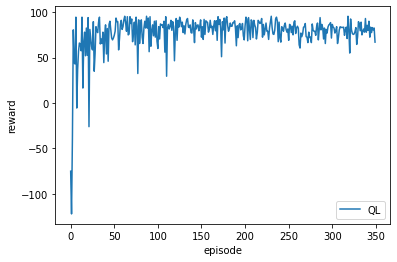

In [14]:
env = GridworldEnv()
env._render()
one_QL_agent = QLAgent(env=env)
one_QL_agent.take_action(num_episode)
plt.plot(list(range(len(one_QL_agent.episodes_reward))),one_QL_agent.episodes_reward)
print('rewards in each episode:',one_QL_agent.episodes_reward)
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend(['QL'])


Repeating Q Learning Algorithm for 200 times
and Calculating the Average

       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
mean application reward is 87.18


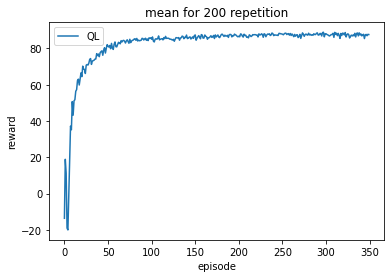

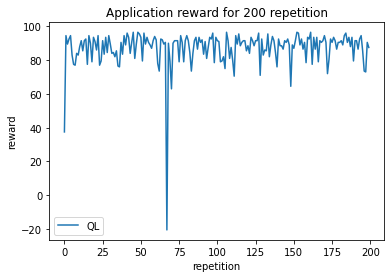

In [15]:
QL_Algorithm=repeat_QL()
QL_Algorithm.n_times(num_episode,n)

plt.plot(list(range(len(QL_Algorithm.ER_list_mean))),QL_Algorithm.ER_list_mean)
plt.title('mean for {} repetition'.format(n))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend(['QL'])


plt.figure()
plt.plot(list(range(len(QL_Algorithm.app_reward))),QL_Algorithm.app_reward)
plt.title('Application reward for {} repetition'.format(n))
plt.xlabel('repetition')
plt.ylabel('reward')
plt.legend(['QL'])
print('mean application reward is {}'.format(sum(QL_Algorithm.app_reward)/len(QL_Algorithm.app_reward)))

Q learning with epsilon decay

       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
mean application reward is 87.4075


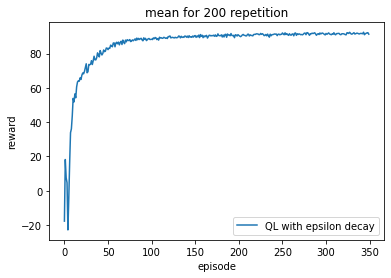

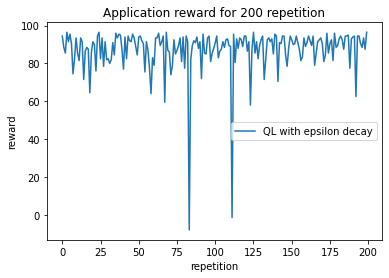

In [16]:
QL_eps_decay=repeat_QL(eps_decay=True)
QL_eps_decay.n_times(num_episode,n)

plt.plot(list(range(len(QL_eps_decay.ER_list_mean))),QL_eps_decay.ER_list_mean)
plt.title('mean for {} repetition'.format(n))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend(['QL with epsilon decay'])

plt.figure()
plt.plot(list(range(len(QL_eps_decay.app_reward))),QL_eps_decay.app_reward)
plt.title('Application reward for {} repetition'.format(n))
plt.xlabel('repetition')
plt.ylabel('reward')
plt.legend(['QL with epsilon decay'])
print('mean application reward is {}'.format(sum(QL_eps_decay.app_reward)/len(QL_eps_decay.app_reward)))

QL with alpha decay for 200 repetition

       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  


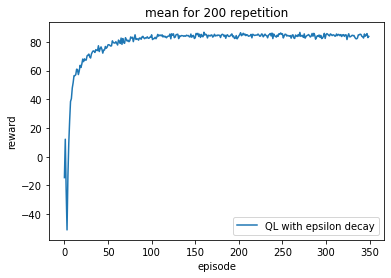

In [17]:
QL_alpha_decay=repeat_QL(alpha_decay=True)
QL_alpha_decay.n_times(num_episode,n)

plt.plot(list(range(len(QL_alpha_decay.ER_list_mean))),QL_alpha_decay.ER_list_mean)
plt.title('mean for {} repetition'.format(n))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend(['QL with epsilon decay'])

Q Learning Comparison

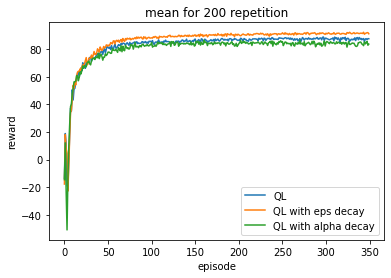

In [18]:
plt.plot(list(range(len(QL_Algorithm.ER_list_mean))),QL_Algorithm.ER_list_mean)
plt.plot(list(range(len(QL_eps_decay.ER_list_mean))),QL_eps_decay.ER_list_mean)
plt.plot(list(range(len(QL_alpha_decay.ER_list_mean))),QL_alpha_decay.ER_list_mean)
plt.title('mean for {} repetition'.format(n))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend(['QL','QL with eps decay','QL with alpha decay'])

Comparison between a Sarsa agent and a QL agent

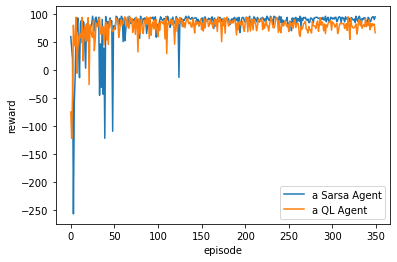

In [19]:
plt.plot(list(range(len(one_sarsa_agent.episodes_reward))),one_sarsa_agent.episodes_reward)
plt.plot(list(range(len(one_QL_agent.episodes_reward))),one_QL_agent.episodes_reward)
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend(['a Sarsa Agent','a QL Agent'])

Comparison between Sarsa and Q learning

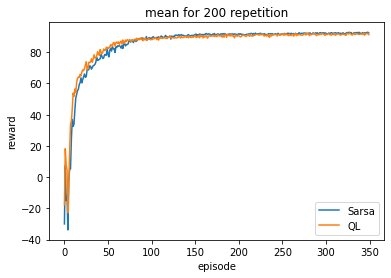

In [20]:
plt.plot(list(range(len(Sarsa_eps_decay.ER_list_mean))),Sarsa_eps_decay.ER_list_mean)
plt.plot(list(range(len(QL_eps_decay.ER_list_mean))),QL_eps_decay.ER_list_mean)
plt.title('mean for {} repetition'.format(n))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend(['Sarsa','QL'])

Comparison between Sarsa and Q learning with epsilon decay

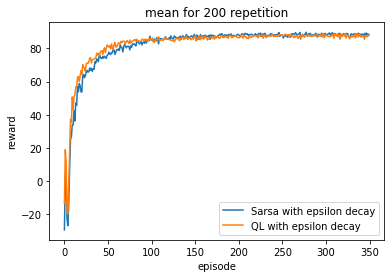

In [21]:
plt.plot(list(range(len(Sarsa_Algorithm.ER_list_mean))),Sarsa_Algorithm.ER_list_mean)
plt.plot(list(range(len(QL_Algorithm.ER_list_mean))),QL_Algorithm.ER_list_mean)
plt.title('mean for {} repetition'.format(n))
plt.xlabel('episode')
plt.ylabel('reward')
plt.legend(['Sarsa with epsilon decay','QL with epsilon decay'])